In [4]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)
print(df.shape)
print(df.head(50))


(58884, 12)
                 MR10_unmod_1  MR11_unmod_2  MR12_unmod_3  MR1_NT_1  MR2_NT_2  MR3_NT_3  MR4_Amide3_1  MR5_Amide3_2  MR6_Amide3_3  MR7_GNA7_1  MR8_GNA7_2  MR9_GNA7_3
ENSG00000000003           419           212           335       355       314       547           417           393           416         613         478         329
ENSG00000000005             3             0             2         4         5         1             2             3             1           0           0           0
ENSG00000000419           550           365           569       423       325       655           515           570           603         861         675         491
ENSG00000000457           216           127           155       128       107       150           149           133           131         235         187         123
ENSG00000000460           550           304           486       422       394       482           475           440           506         712         554     

In [17]:
## REMOVE DATA WHERE ALL THREE AVG ARE BELOW 50
import pandas as pd

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df['unmod_avg'] = df[unmod_cols].mean(axis=1)
df['nt_avg'] = df[nt_cols].mean(axis=1)
df['amide_avg'] = df[amide_cols].mean(axis=1)
df['gna_avg'] = df[gna_cols].mean(axis=1)

df_filtered = df[(df[['unmod_avg', 'nt_avg', 'amide_avg', 'gna_avg']] >= 50).any(axis=1)]

df_filtered = df_filtered.drop(columns=['unmod_avg', 'nt_avg', 'amide_avg', 'gna_avg'])

print(df_filtered.shape)
print(df_filtered.head(1))


(11312, 12)
                 MR10_unmod_1  MR11_unmod_2  MR12_unmod_3  MR1_NT_1  MR2_NT_2  MR3_NT_3  MR4_Amide3_1  MR5_Amide3_2  MR6_Amide3_3  MR7_GNA7_1  MR8_GNA7_2  MR9_GNA7_3
ENSG00000000003           419           212           335       355       314       547           417           393           416         613         478         329


In [ ]:
### FINDINGS ONLY SEED MATCHED DATA / ONE ENTRY AT A TIME
### REQUIRES FILTERED_DF
import requests
import pandas as pd

def fetch_sequences_batch(ensembl_ids):
    url = "https://rest.ensembl.org/sequence/id"
    headers = {"Content-Type": "application/json"}
    data = {"ids": ensembl_ids}
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()
    else:
        return None

pd.set_option('display.max_colwidth', None)

batch_size = 50
ensembl_ids = list(df_filtered.index)

for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    sequences = fetch_sequences_batch(batch_ids)
    
    if sequences:
        for seq_info in sequences:
            sequence = seq_info['seq']
            ensembl_id = seq_info['id']
            if 'ATCTCCTA' in sequence:
                match_index = sequence.find('ATCTCCTA')
                start = max(0, match_index - 50)
                end = min(len(sequence), match_index + len('ATCTCCTA') + 50)
                region = sequence[start:end]
                print(f"Ensembl ID: {ensembl_id}")
                print(f"Sequence Length: {len(sequence)}")
                print(f"Region around match: {region}")


In [ ]:
### FINDINGS ONLY SEED MATCHED DATA / BATCHES OF 50
### REQUIRES FILTERED_DF
import requests
import pandas as pd

def fetch_sequences_batch(ensembl_ids):
    url = "https://rest.ensembl.org/sequence/id"
    headers = {"Content-Type": "application/json"}
    data = {"ids": ensembl_ids}
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()
    else:
        return None

pd.set_option('display.max_colwidth', None)

batch_size = 50
ensembl_ids = list(df_filtered.index)
matches = []

for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    sequences = fetch_sequences_batch(batch_ids)
    
    if sequences:
        for seq_info in sequences:
            sequence = seq_info['seq']
            ensembl_id = seq_info['id']
            if 'ATCTCCTA' in sequence:
                match_index = sequence.find('ATCTCCTA')
                start = max(0, match_index - 50)
                end = min(len(sequence), match_index + len('ATCTCCTA') + 50)
                region = sequence[start:end]
                df_filtered.loc[ensembl_id, 'region_around_match'] = region
                df_filtered.loc[ensembl_id, 'sequence_length'] = len(sequence)
                matches.append(df_filtered.loc[ensembl_id])

if matches:
    matches_df = pd.DataFrame(matches)
    matches_df.to_csv('matched_sequences.csv', index=True)


In [ ]:
## COLLECT SEED MATCH, NO FILTER AT 50
import pandas as pd

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

print(df.shape)
print(df.head(1))


### FINDINGS ONLY SEED MATCHED DATA / BATCHES OF 50
### REQUIRES FILTERED_DF
import requests
import pandas as pd

def fetch_sequences_batch(ensembl_ids):
    url = "https://rest.ensembl.org/sequence/id"
    headers = {"Content-Type": "application/json"}
    data = {"ids": ensembl_ids}
    response = requests.post(url, headers=headers, json=data)
    if response.status_code == 200:
        return response.json()
    else:
        return None

pd.set_option('display.max_colwidth', None)

batch_size = 50
ensembl_ids = list(df.index)
matches = []

for i in range(0, len(ensembl_ids), batch_size):
    batch_ids = ensembl_ids[i:i + batch_size]
    sequences = fetch_sequences_batch(batch_ids)
    
    if sequences:
        for seq_info in sequences:
            sequence = seq_info['seq']
            ensembl_id = seq_info['id']
            if 'ATCTCCTA' in sequence:
                match_index = sequence.find('ATCTCCTA')
                start = max(0, match_index - 50)
                end = min(len(sequence), match_index + len('ATCTCCTA') + 50)
                region = sequence[start:end]
                df.loc[ensembl_id, 'region_around_match'] = region
                df.loc[ensembl_id, 'sequence_length'] = len(sequence)
                matches.append(df.loc[ensembl_id])

if matches:
    matches_df = pd.DataFrame(matches)
    matches_df.to_csv('matched_sequences2.csv', index=True)


In [ ]:
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('matched_sequences.csv', index_col=0)
df = df.drop(columns=['region_around_match', 'sequence_length'])

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df['mean_nt'] = df[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df['mean_unmod'] = df[unmod_cols].mean(axis=1)
df['mean_amide'] = df[amide_cols].mean(axis=1)
df['mean_gna'] = df[gna_cols].mean(axis=1)

df['log2FC_unmod_vs_nt'] = np.log2(df['mean_unmod'] / df['mean_nt'])
df['log2FC_amide_vs_nt'] = np.log2(df['mean_amide'] / df['mean_nt'])
df['log2FC_gna_vs_nt'] = np.log2(df['mean_gna'] / df['mean_nt'])

def ma_plot(mean_nt, log2fc, title):
    diff_expressed = (log2fc > 1) | (log2fc < -1)
    plt.scatter(mean_nt[~diff_expressed], log2fc[~diff_expressed], alpha=0.5, label="Not DE")
    plt.scatter(mean_nt[diff_expressed], log2fc[diff_expressed], alpha=0.7, color='red', label="DE")
    plt.xscale('log')
    plt.ylim(-3, 3)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.show()

ma_plot(df['mean_nt'], df['log2FC_unmod_vs_nt'], 'Unmod vs NT')
ma_plot(df['mean_nt'], df['log2FC_amide_vs_nt'], 'Amide vs NT')
ma_plot(df['mean_nt'], df['log2FC_gna_vs_nt'], 'GNA vs NT')


In [ ]:
### HIGHER RES MA PLOTS, FULL DATA, NOT NORMALIZED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df['mean_nt'] = df[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df['mean_unmod'] = df[unmod_cols].mean(axis=1)
df['mean_amide'] = df[amide_cols].mean(axis=1)
df['mean_gna'] = df[gna_cols].mean(axis=1)

df['mean_nt'].replace(0, 1e-9, inplace=True)
df['mean_unmod'].replace(0, 1e-9, inplace=True)
df['mean_amide'].replace(0, 1e-9, inplace=True)
df['mean_gna'].replace(0, 1e-9, inplace=True)

df['log2FC_unmod_vs_nt'] = np.log2(df['mean_unmod'] / df['mean_nt'])
df['log2FC_amide_vs_nt'] = np.log2(df['mean_amide'] / df['mean_nt'])
df['log2FC_gna_vs_nt'] = np.log2(df['mean_gna'] / df['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    plt.figure(figsize=(10, 8), dpi=300)  # Set high resolution with small points
    plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)  # Tiny points for clarity
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

ma_plot_high_res(df['mean_nt'], df['log2FC_unmod_vs_nt'], 'Unmod vs NT', 'unmod_vs_nt_high_res.png')
ma_plot_high_res(df['mean_nt'], df['log2FC_amide_vs_nt'], 'Amide vs NT', 'amide_vs_nt_high_res.png')
ma_plot_high_res(df['mean_nt'], df['log2FC_gna_vs_nt'], 'GNA vs NT', 'gna_vs_nt_high_res.png')


In [ ]:
## HIGHER RES MA PLOTS, NORMALIZED, WITH CUT OFF AT 0.5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**0.5, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')


In [ ]:
### MA PLOT USING PLOTLY. OPTION TO REMOVE THE CUTOFF
import pandas as pd
import numpy as np
import plotly.express as px

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

hide_below_05 = False

if hide_below_05:
    mask = df_normalized['mean_nt'] > 10**0.5
else:
    mask = df_normalized.index

def plotly_ma_plot(mean_counts, log_ratio, title):
    fig = px.scatter(x=mean_counts[mask], y=log_ratio[mask],
                     labels={'x': 'Mean of normalized counts', 'y': 'Log2 Fold Change'},
                     title=title)
    fig.update_xaxes(type="log", range=[0.4, 6])
    fig.update_yaxes(range=[-4, 4])
    fig.show()

plotly_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Plotly Unmod vs NT')
# plotly_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Plotly Amide vs NT')
# plotly_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Plotly GNA vs NT')



In [ ]:
### DATASHADER, ALSO PRETTY BAD GRAPHS
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def datashader_plot(df, title):
    # Adjust the canvas with a modified x_range to include higher values
    canvas = ds.Canvas(plot_width=600, plot_height=400, x_range=(0, 1000), y_range=(-6, 6))
    agg = canvas.points(df, 'x', 'y')  # Aggregate the points on the canvas

    # Apply a blue colormap
    img = tf.shade(agg, cmap='blue')

    # Plot using Matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(img.to_pil(), aspect='auto')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Create a DataFrame with only the 'mean_nt' and 'log2FC_unmod_vs_nt' columns for plotting
df_plot = pd.DataFrame({'x': df_normalized['mean_nt'], 'y': df_normalized['log2FC_unmod_vs_nt']})
datashader_plot(df_plot, 'Datashader: Adjusted Unmod vs NT')


In [ ]:
## COMBINED MA PLOT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

#########################
matched_sequences = pd.read_csv('matched_sequences.csv')
ensembl_ids = matched_sequences.iloc[:, 0]  # Assuming Ensembl IDs are in the first column
df_filtered = df_normalized[df_normalized.index.isin(ensembl_ids)]
########################

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**0.5, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# ma_plot_high_res(df_filtered['mean_nt'], df_filtered['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_filtered['mean_nt'], df_filtered['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_filtered['mean_nt'], df_filtered['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')


In [ ]:
def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    mask = mean_counts > 10**0.5
    
    plt.figure(figsize=(10, 8), dpi=300)
    
    plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2)
    
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**0.5, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

combined_ma_plot(df_filtered['mean_nt'], df_filtered['log2FC_unmod_vs_nt'], df_filtered['log2FC_amide_vs_nt'], 'Normalized Unmod vs Amide vs NT', 'combined_unmod_amide_vs_nt_high_res.png')


In [ ]:
## COMBINED MA PLOT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '6048D_rawCounts.txt'
df = pd.read_csv(file_path, sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

#########################
matched_sequences = pd.read_csv('matched_sequences.csv')
ensembl_ids = matched_sequences.iloc[:, 0]  # Assuming Ensembl IDs are in the first column
df_filtered = df_normalized[df_normalized.index.isin(ensembl_ids)]
########################


def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    # mask = mean_counts > 10**0.5
    
    plt.figure(figsize=(10, 8), dpi=300)
    
    plt.scatter(mean_counts, log_ratio1, color='red', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    plt.scatter(mean_counts, log_ratio2, color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2)
    
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

combined_ma_plot(df_filtered['mean_nt'], df_filtered['log2FC_unmod_vs_nt'], df_filtered['log2FC_amide_vs_nt'], 'Normalized Unmod vs Amide vs NT', 'combined_unmod_amide_vs_nt_high_res.png')


/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


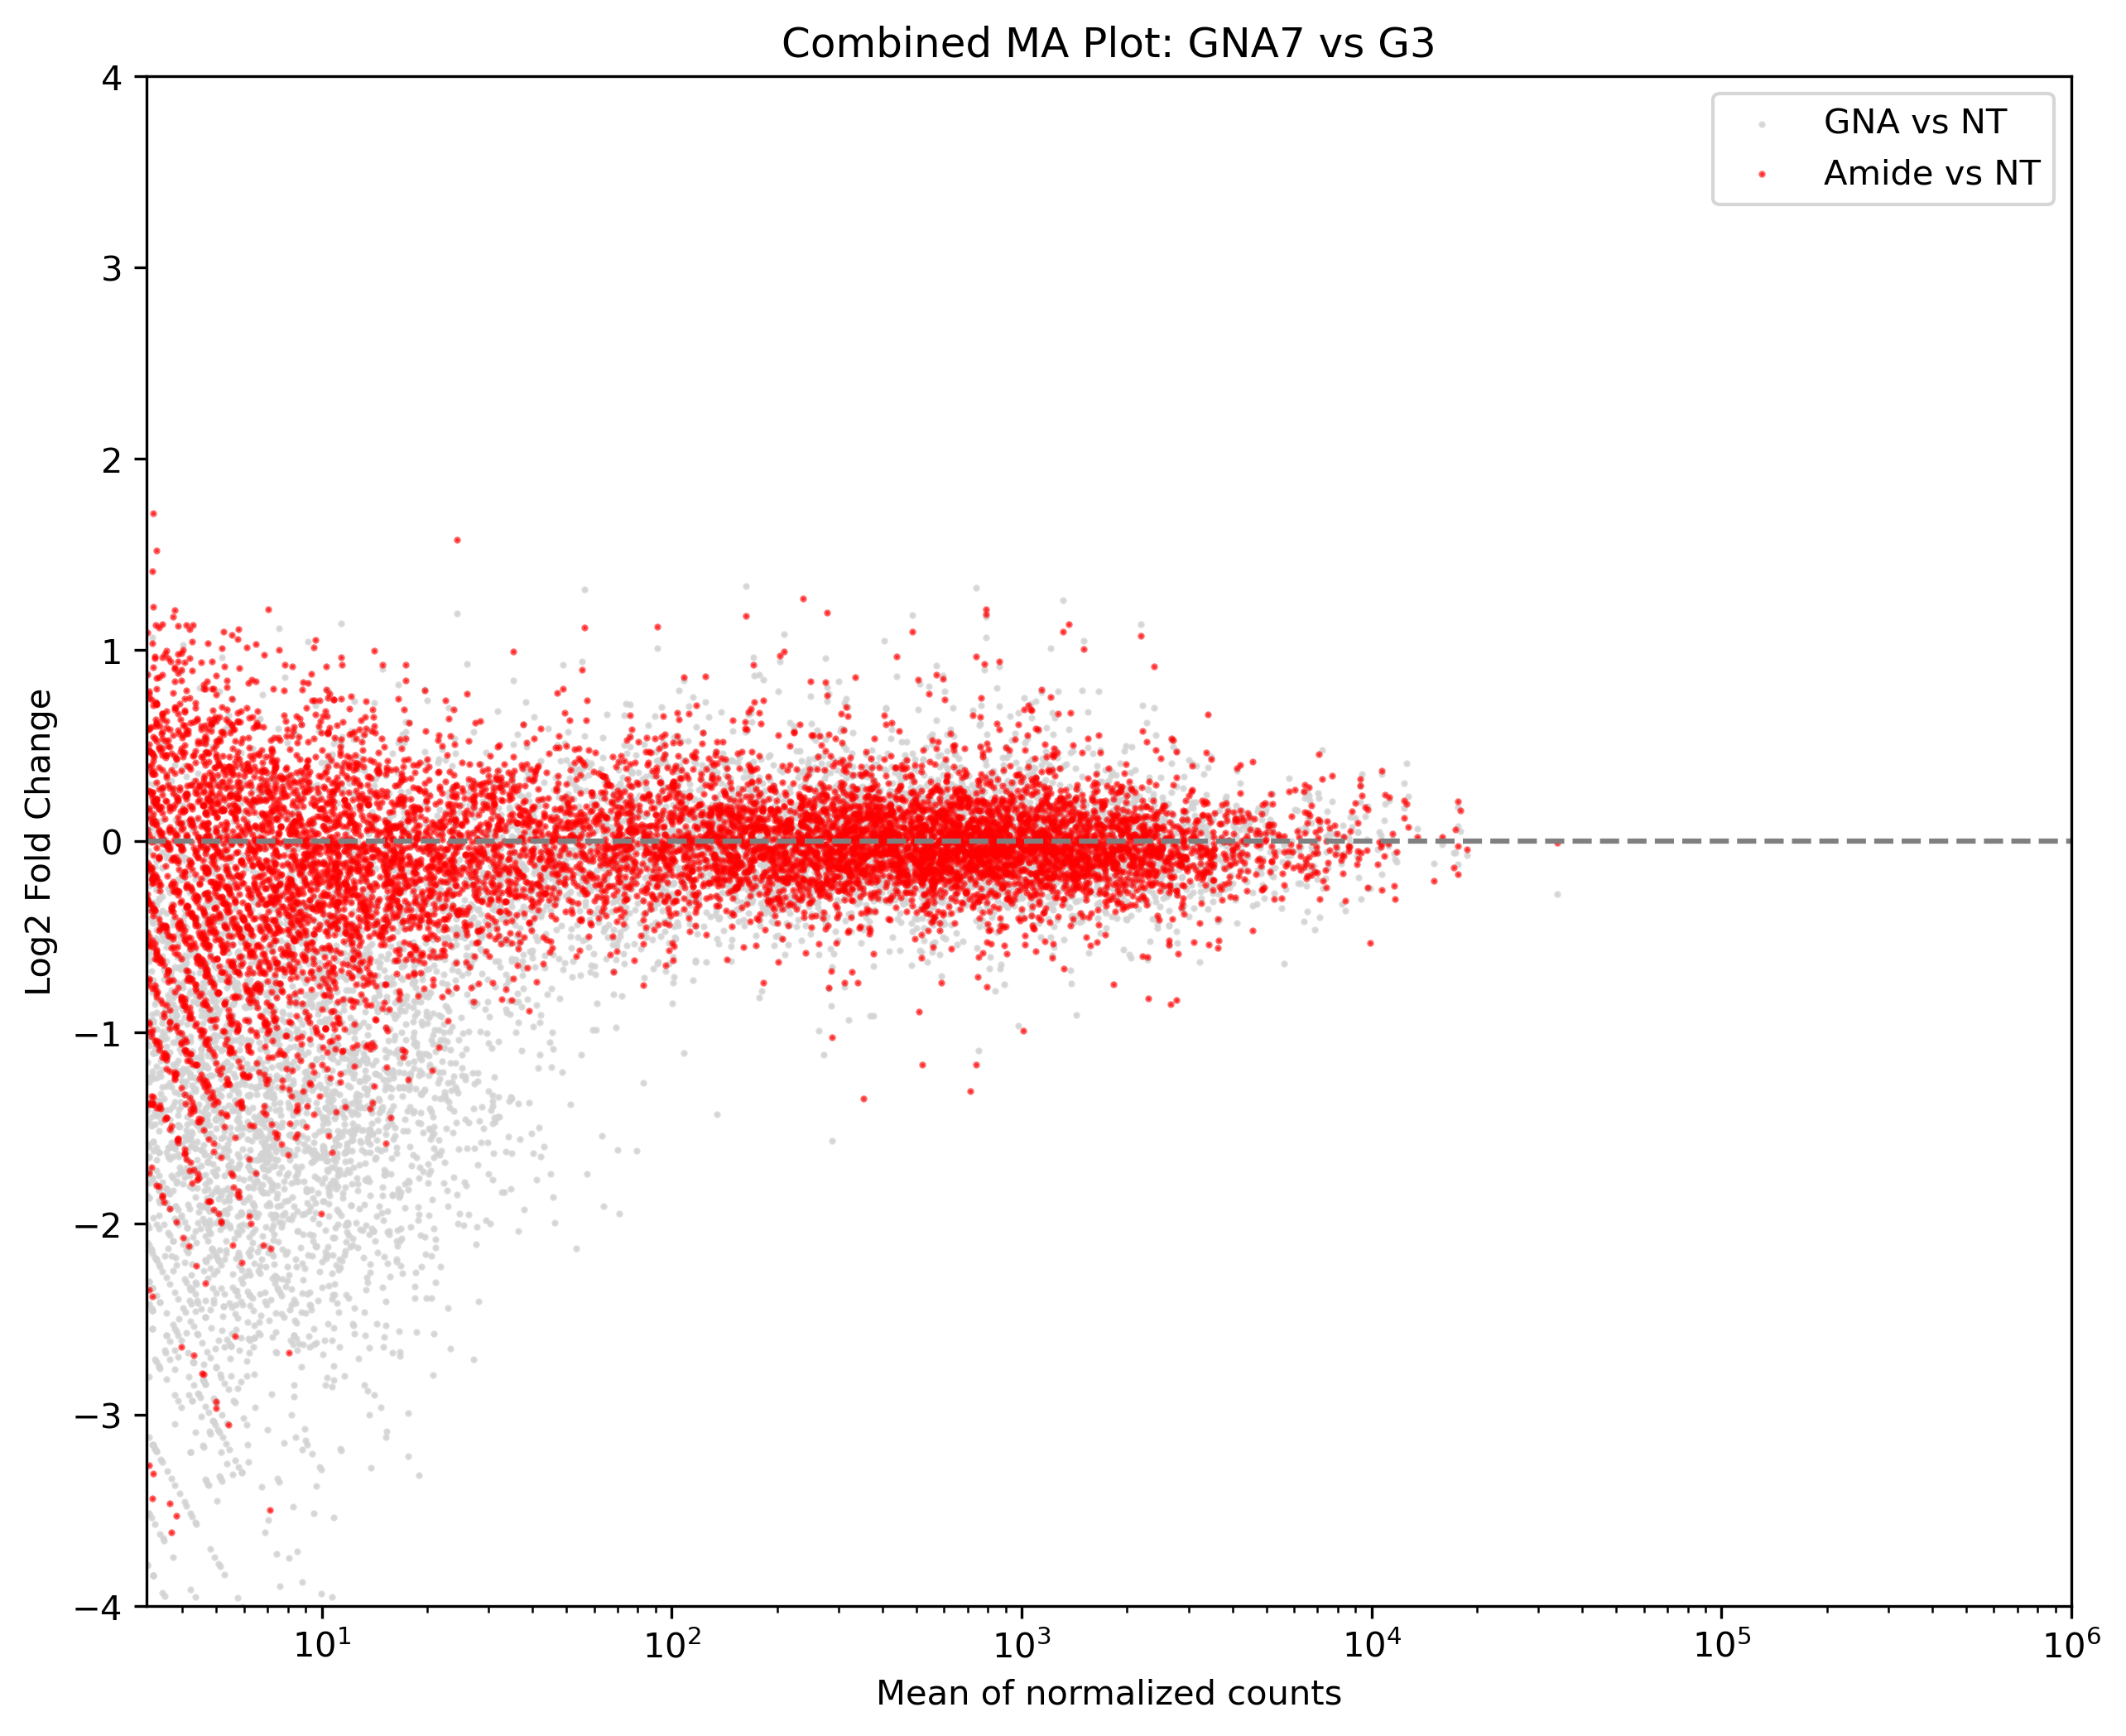

In [5]:
## MATCHES SEQUENCES2 SEED MATCHED DATA, NORMALIZED, NO CUT OFF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('matched_sequences2.csv', index_col=0)
df = df.drop(columns=['region_around_match', 'sequence_length'])

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    # mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    # plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    mask = mean_counts > 10**0.5
    
    plt.figure(figsize=(10, 8), dpi=300)
    
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    plt.scatter(mean_counts[mask], log_ratio1[mask], color='lightgrey', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    plt.scatter(mean_counts[mask], log_ratio2[mask], color='red', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
        
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**0.5, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Unmod vs Amide vs NT', 'combined_unmod_amide_vs_nt_high_res.png')

combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_gna_amide.png')


/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


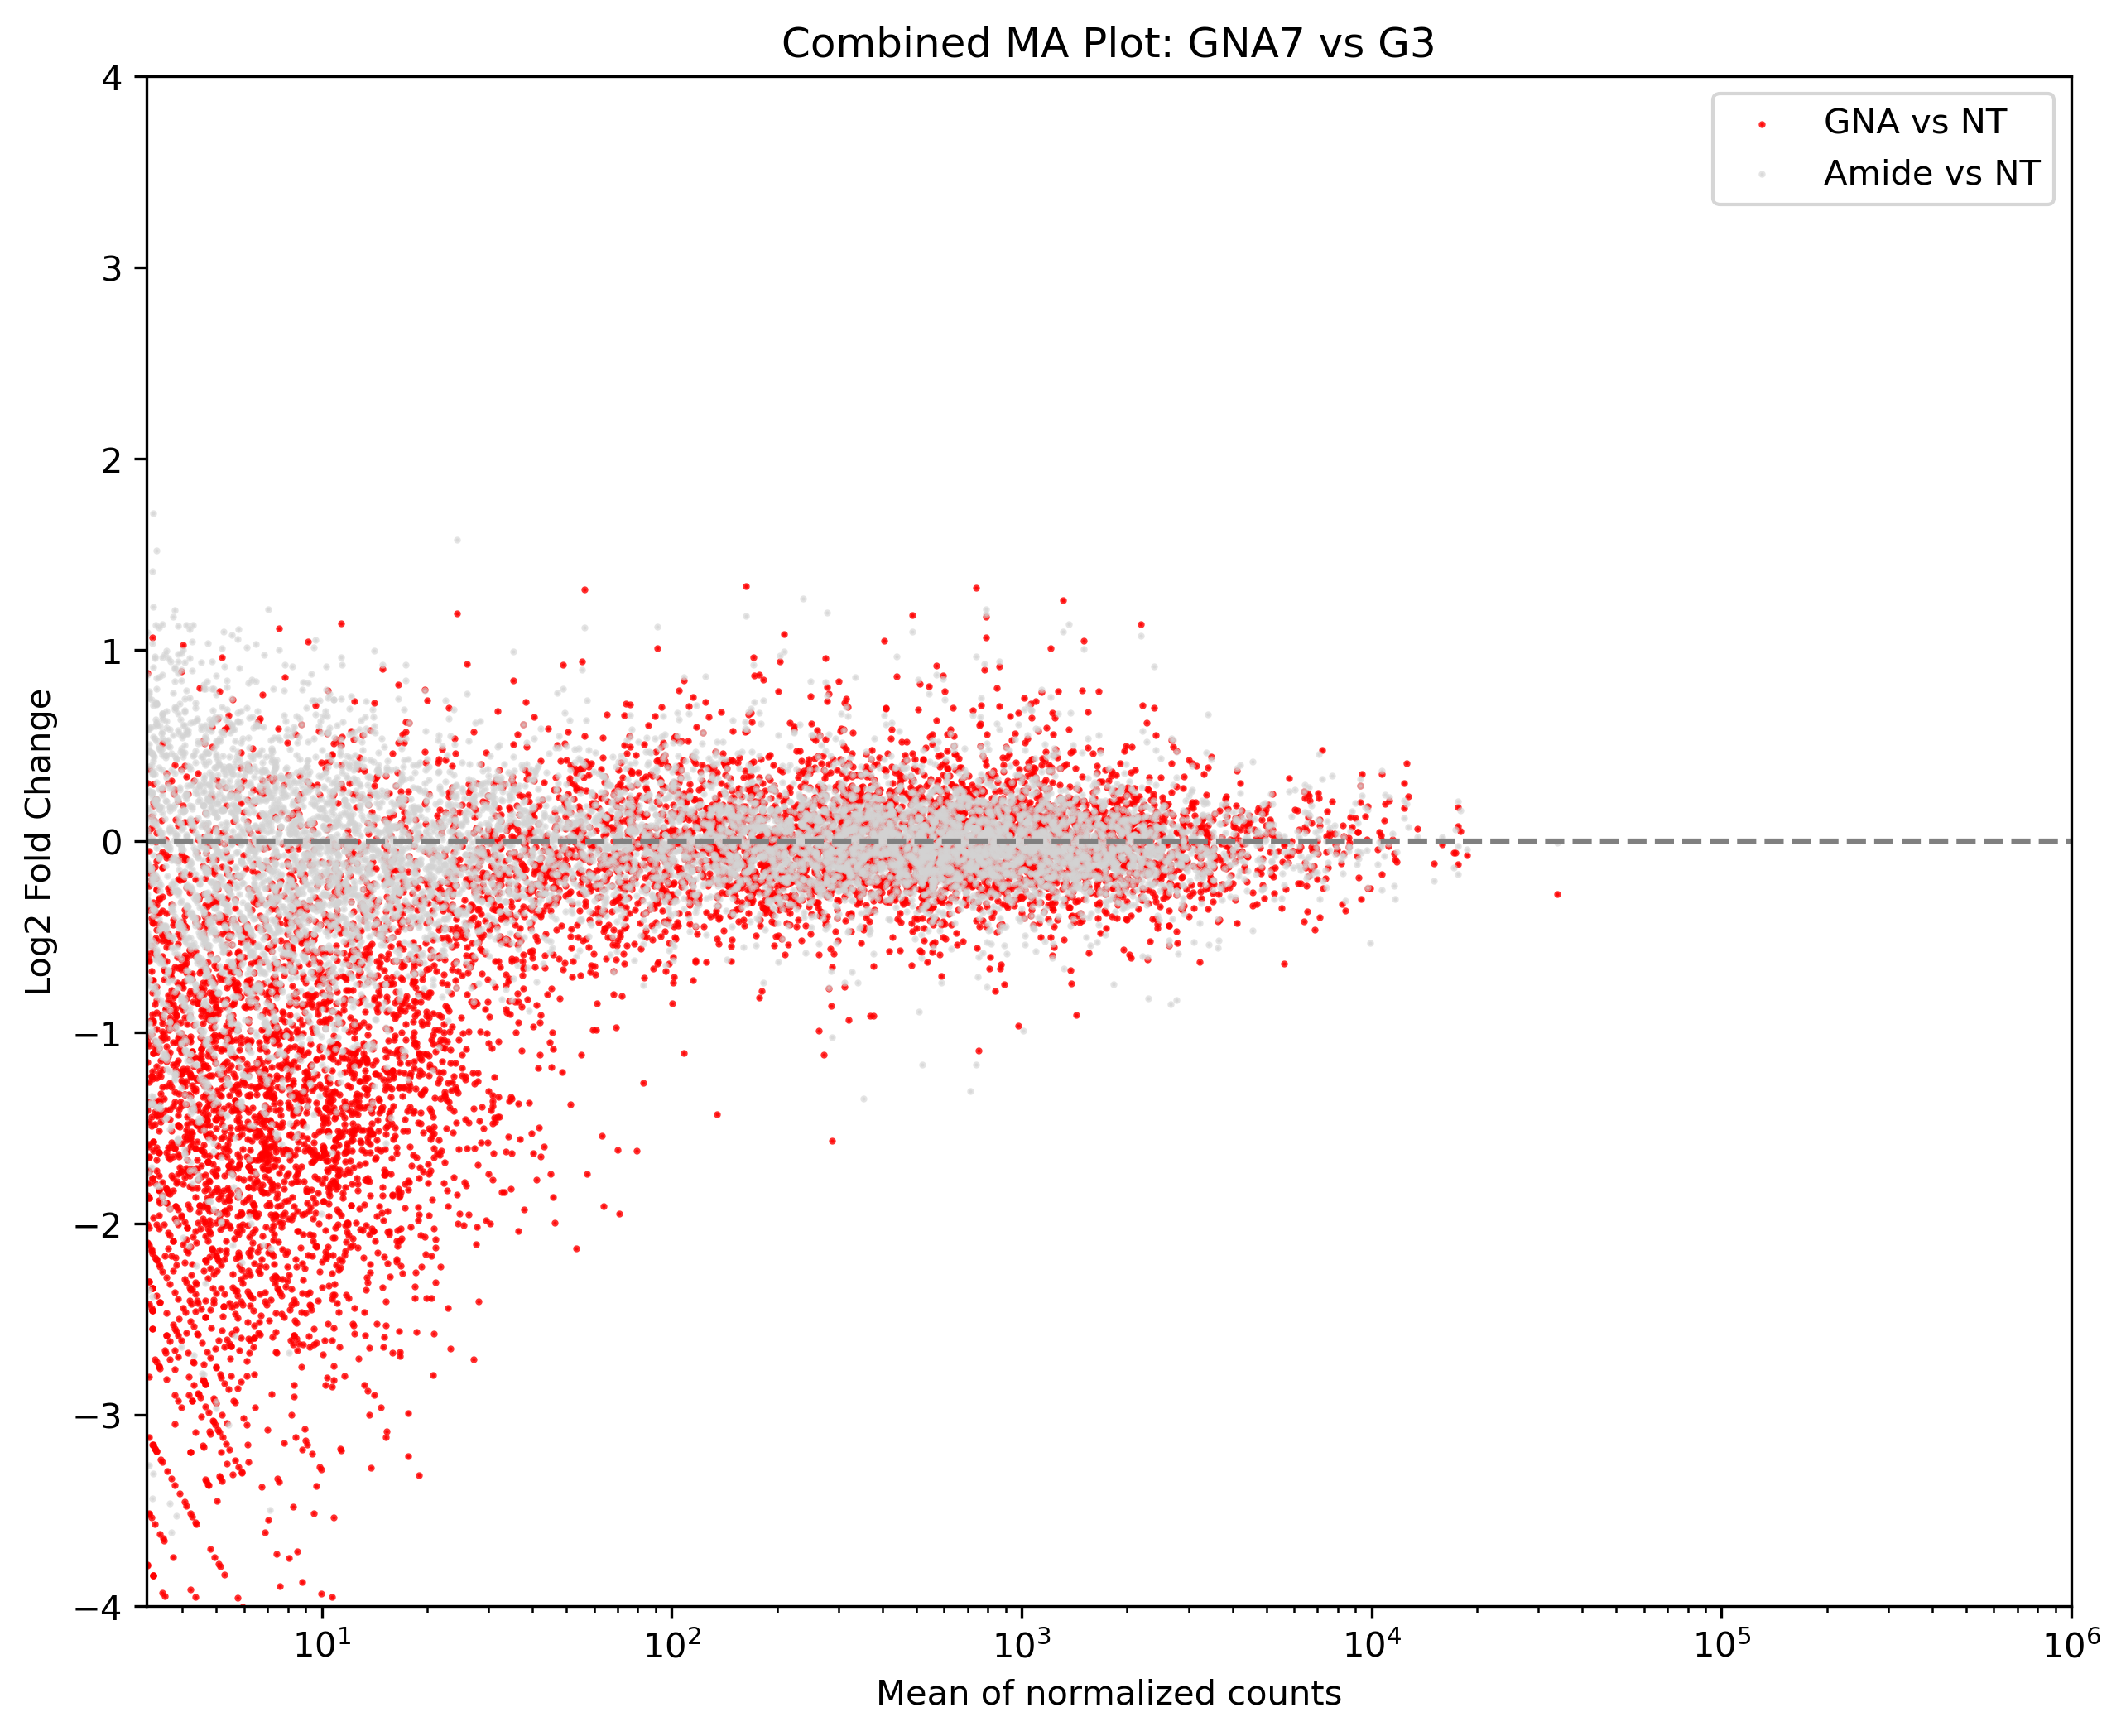

In [8]:
## MAPLOT MATCHES SEQUENCES 2 SEED MATCHED DATA, NORMALIZED, NO CUT OFF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('matched_sequences2.csv', index_col=0)
df = df.drop(columns=['region_around_match', 'sequence_length'])

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    # plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    mask = mean_counts > 10**0.5
    
    plt.figure(figsize=(10, 8), dpi=300)
    
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='lightgrey', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='red', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**0.5, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: Unmod vs G3', 'combined_unmod_amide.png')
combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_unmod_amide.png')


/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


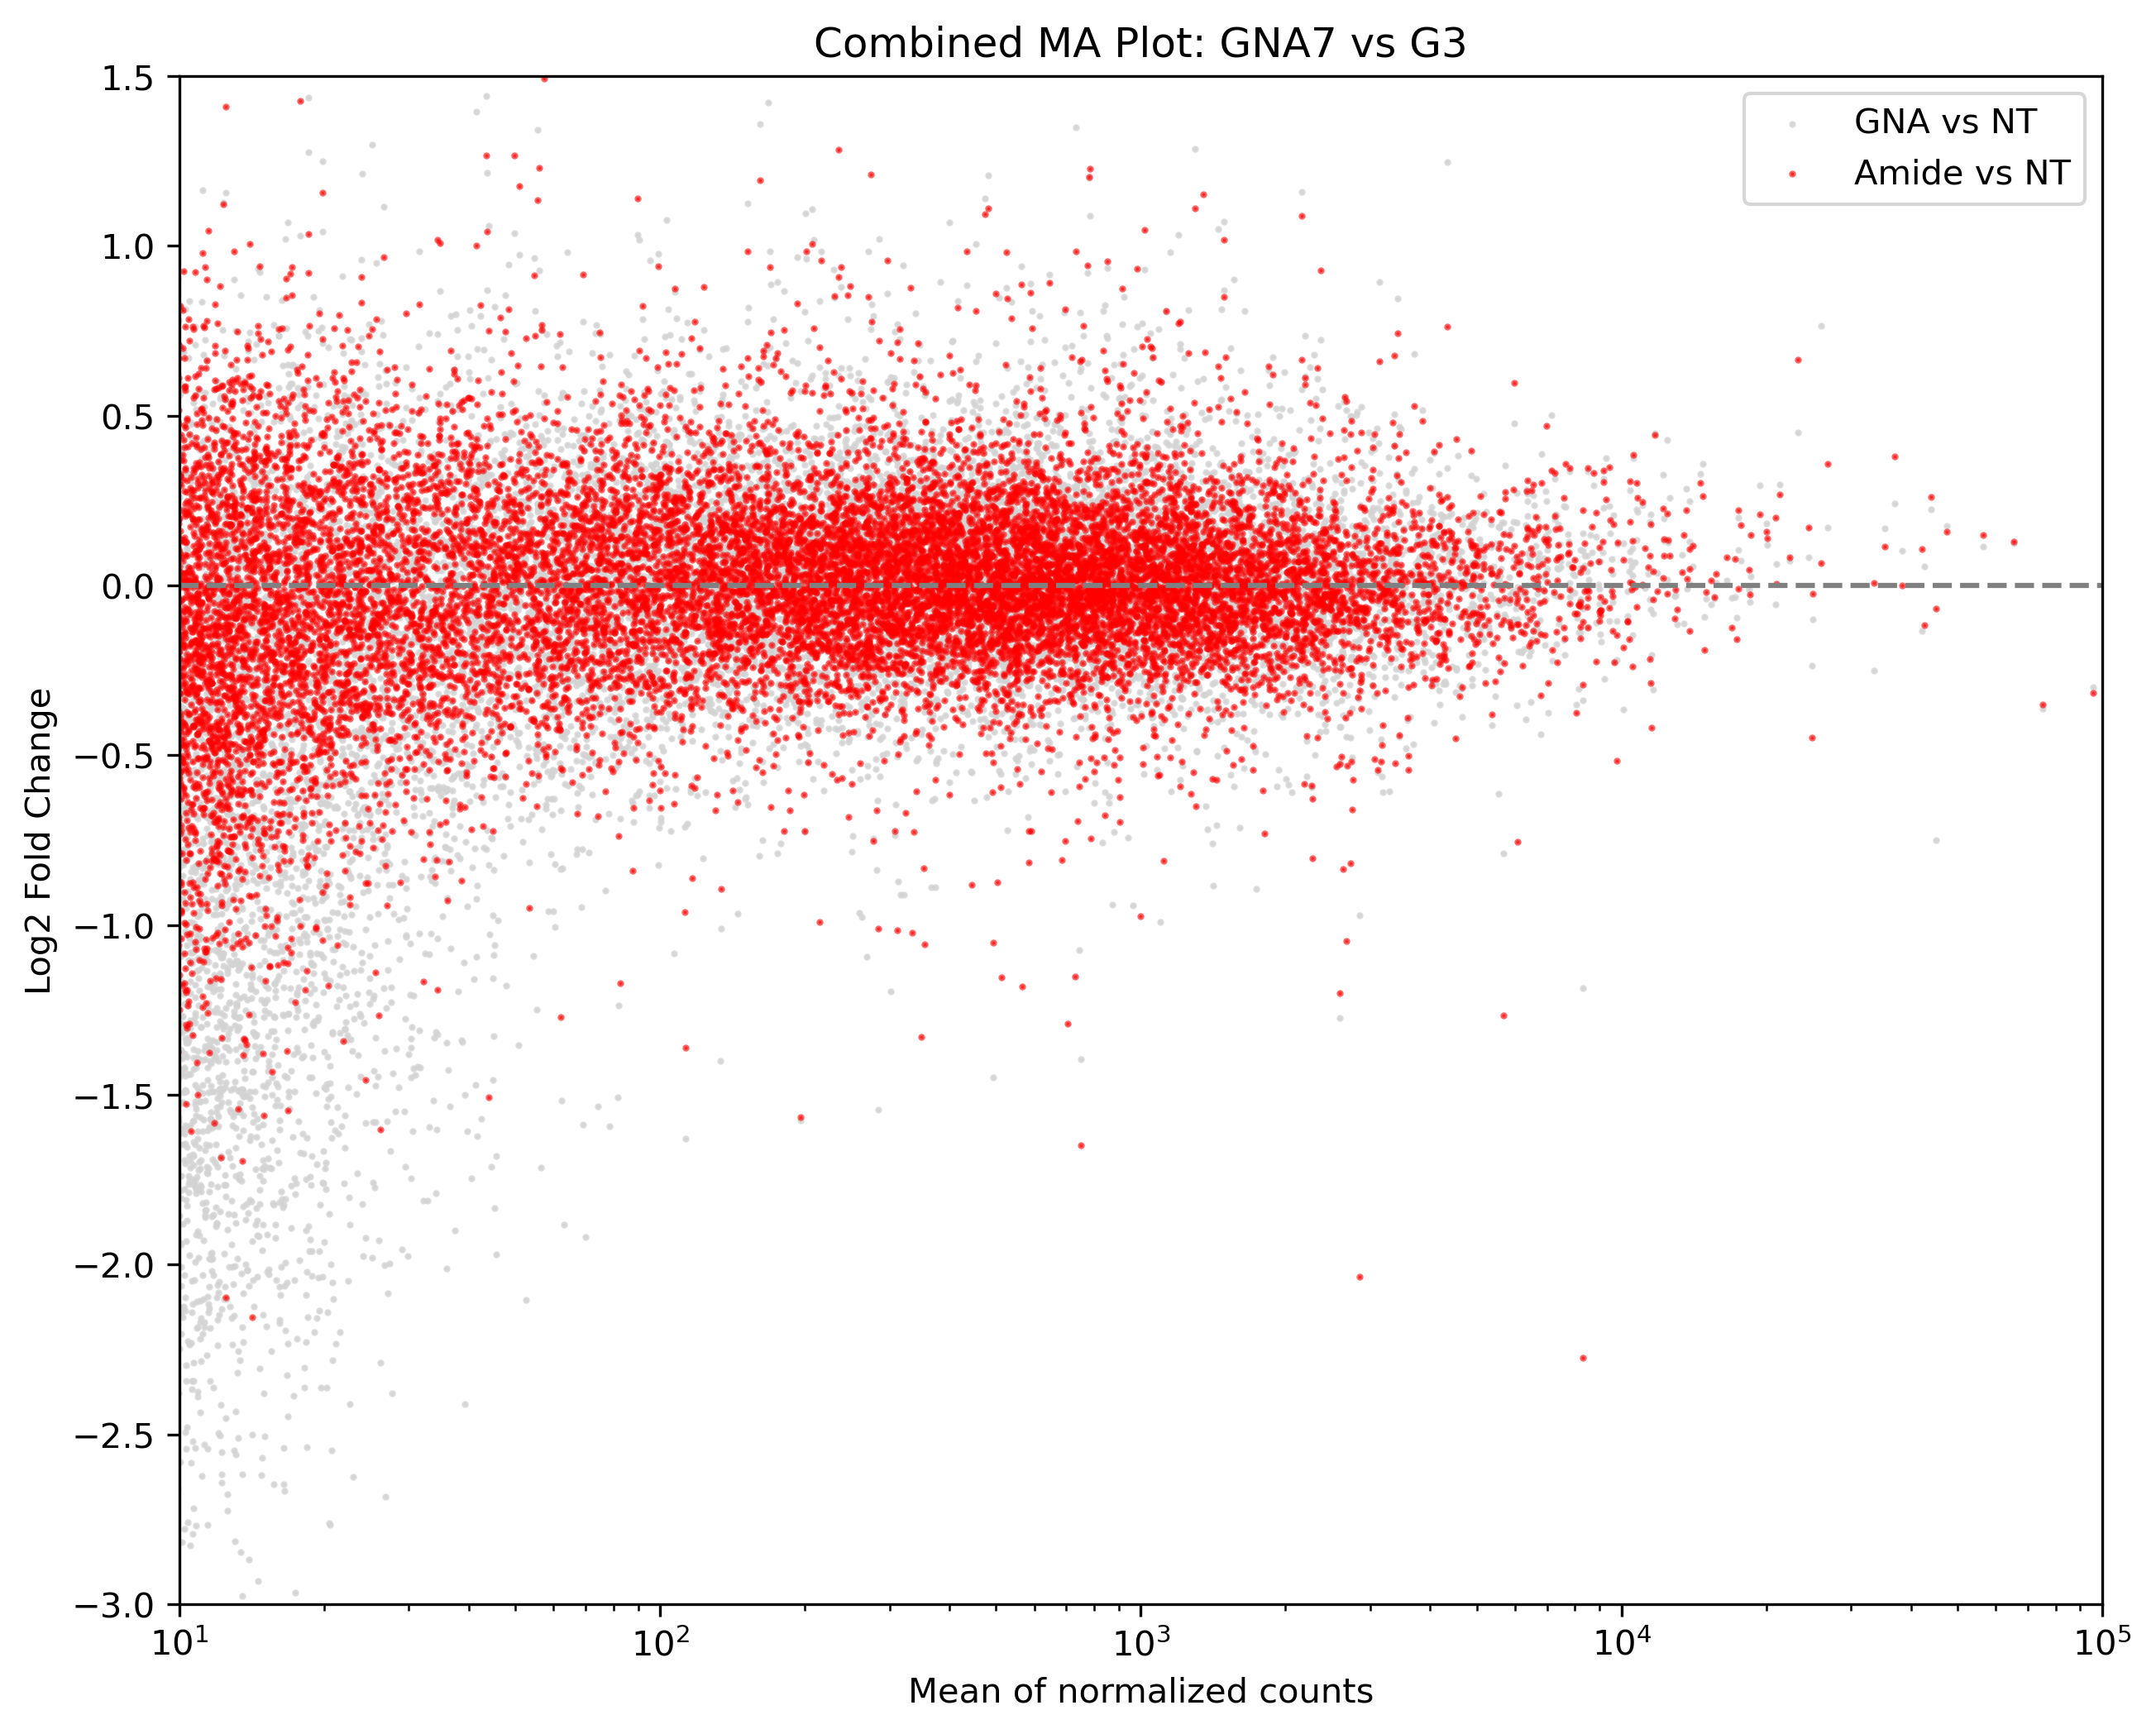

In [1]:
## MAPLOT SEED MATCHED DATA, NORMALIZED, NO CUT OFF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("6048D_rawCounts.txt", sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    # mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    # plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    mask = mean_counts > 10**0.5
    
    plt.figure(figsize=(10, 8), dpi=300)
    
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    plt.scatter(mean_counts[mask], log_ratio1[mask], color='lightgrey', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    plt.scatter(mean_counts[mask], log_ratio2[mask], color='red', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    
    plt.xscale('log')
    plt.ylim(-3, 1.5)
    plt.xlim(10**1, 10**5)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: Unmod vs G3', 'combined_unmod_amide.png')
combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_unmod_amide.png')


/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


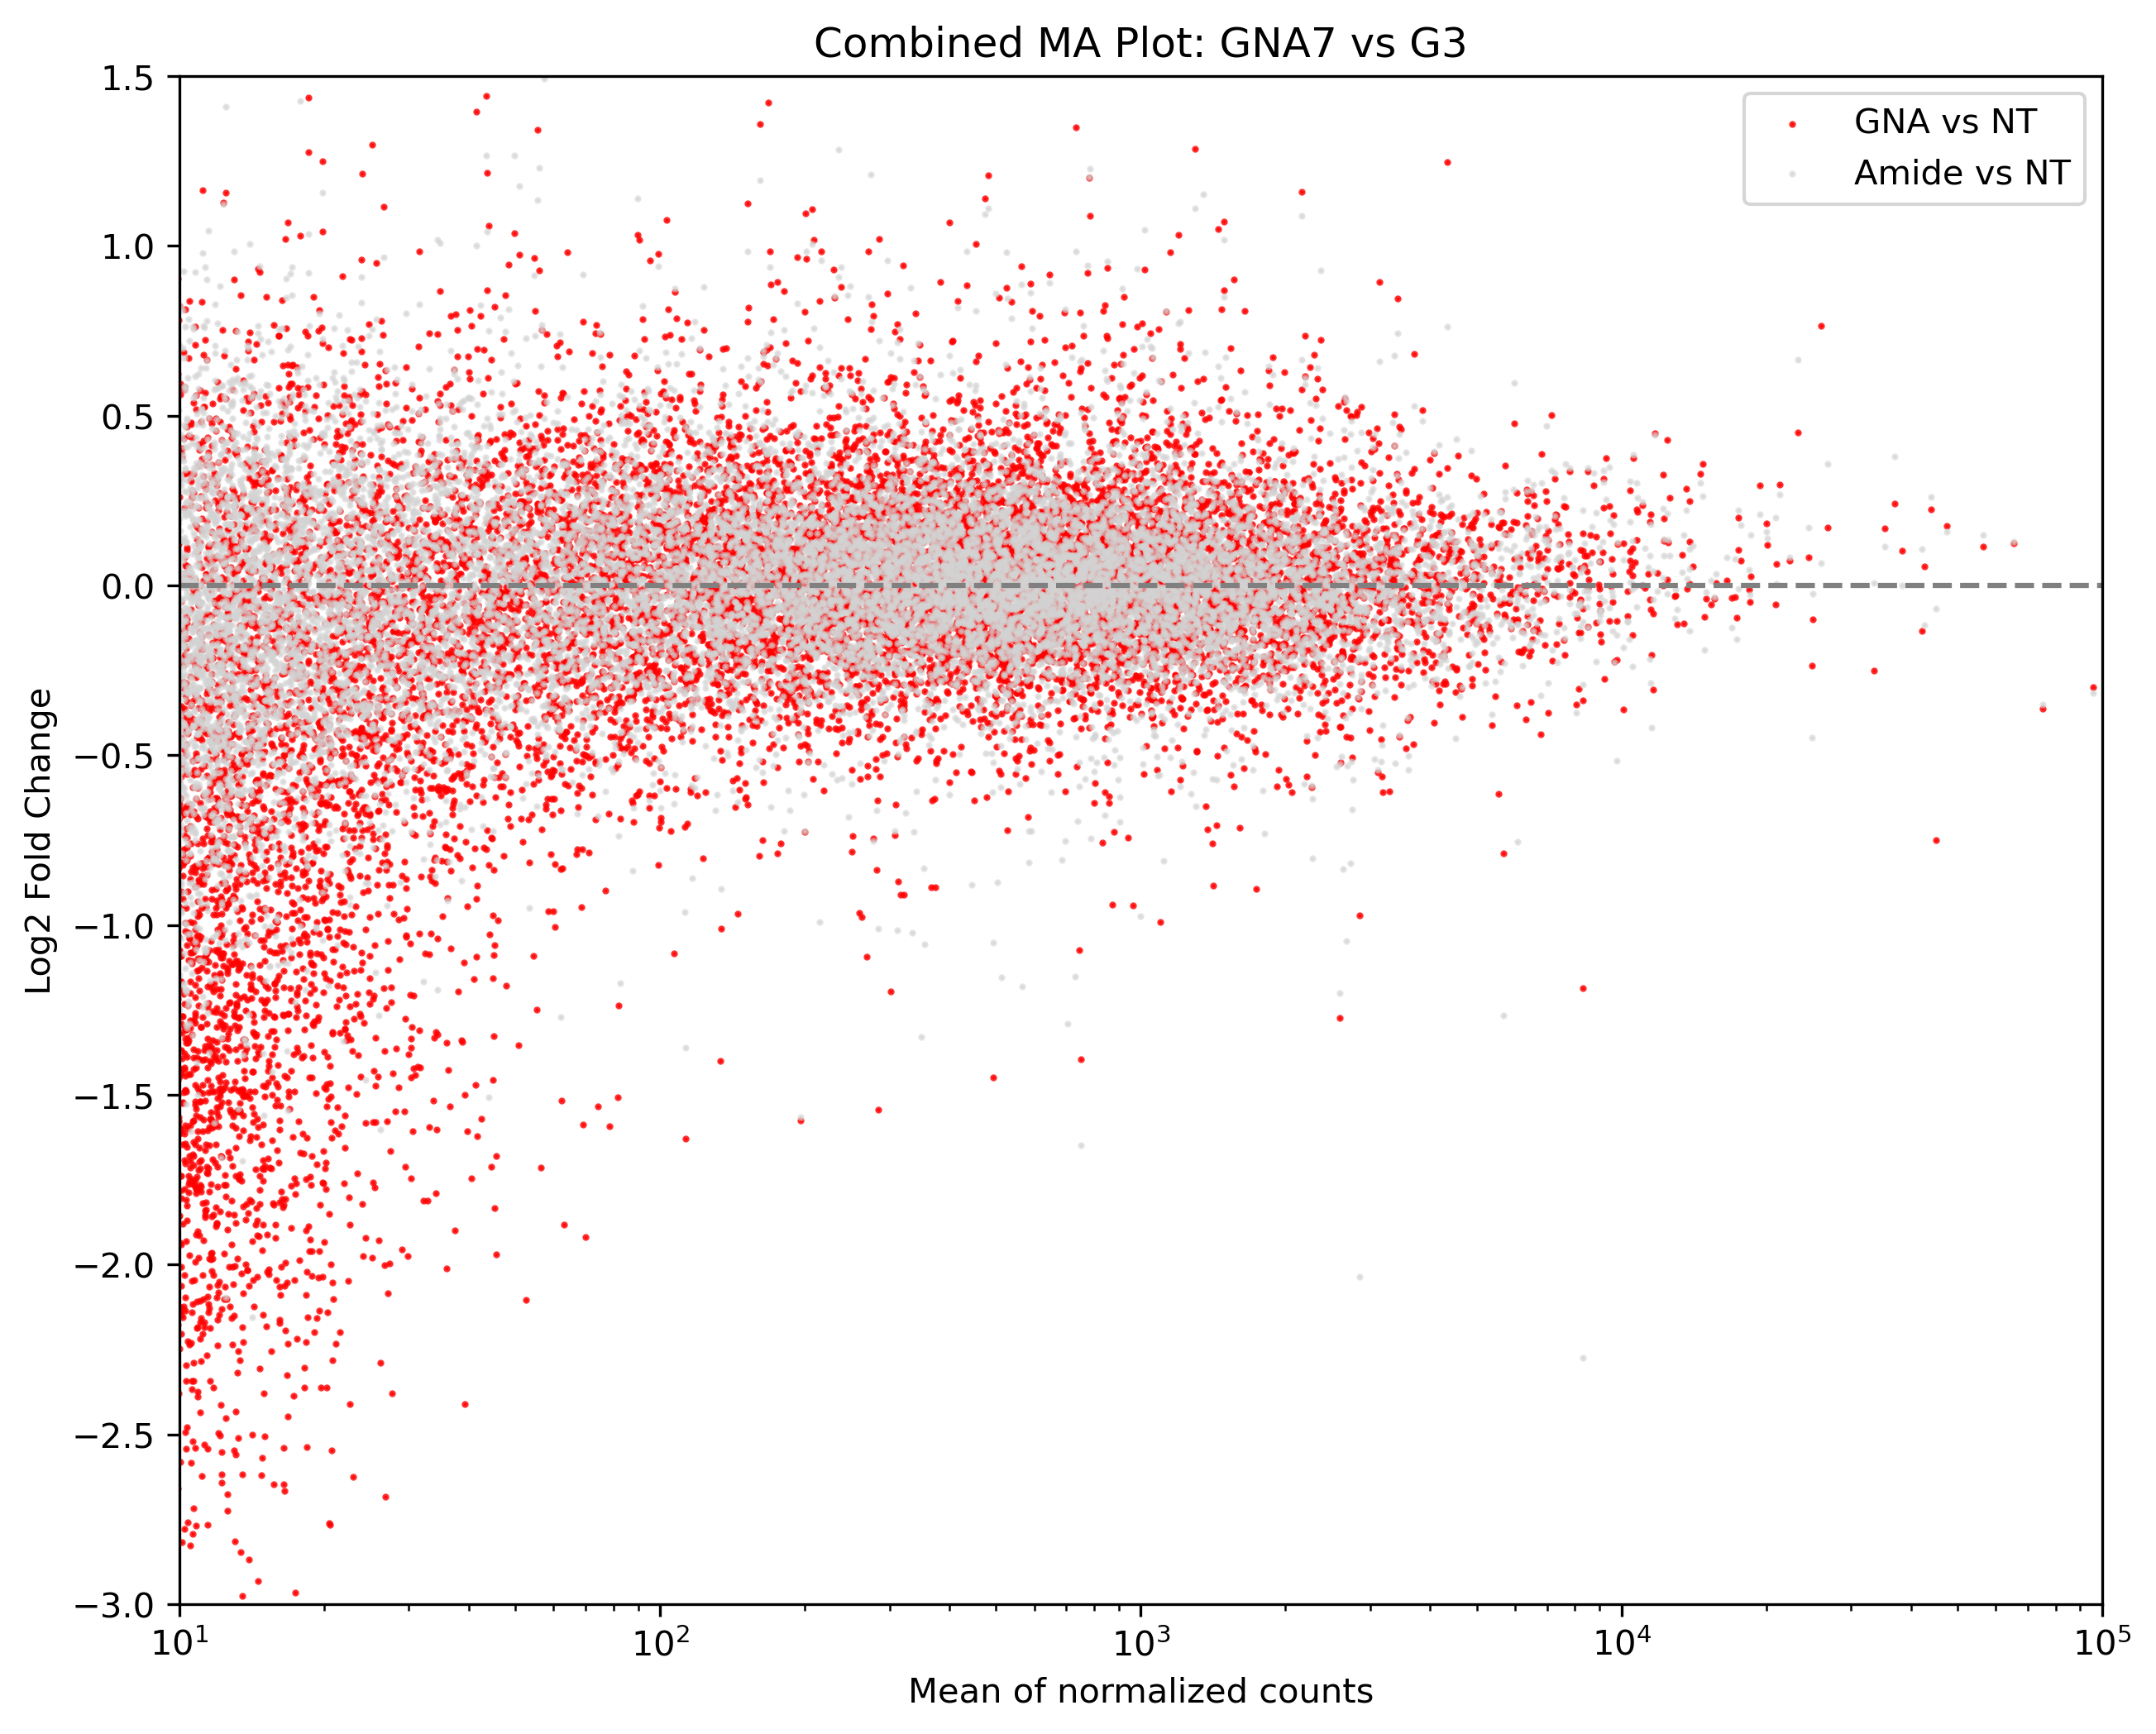

In [2]:
## MAPLOT SEED MATCHED DATA, NORMALIZED, NO CUT OFF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("6048D_rawCounts.txt", sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    # mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    # plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    mask = mean_counts > 10**0.5
    
    plt.figure(figsize=(10, 8), dpi=300)
    
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    
    plt.xscale('log')
    plt.ylim(-3, 1.5)
    plt.xlim(10**1, 10**5)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: Unmod vs G3', 'combined_unmod_amide.png')
combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_unmod_amide.png')


/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


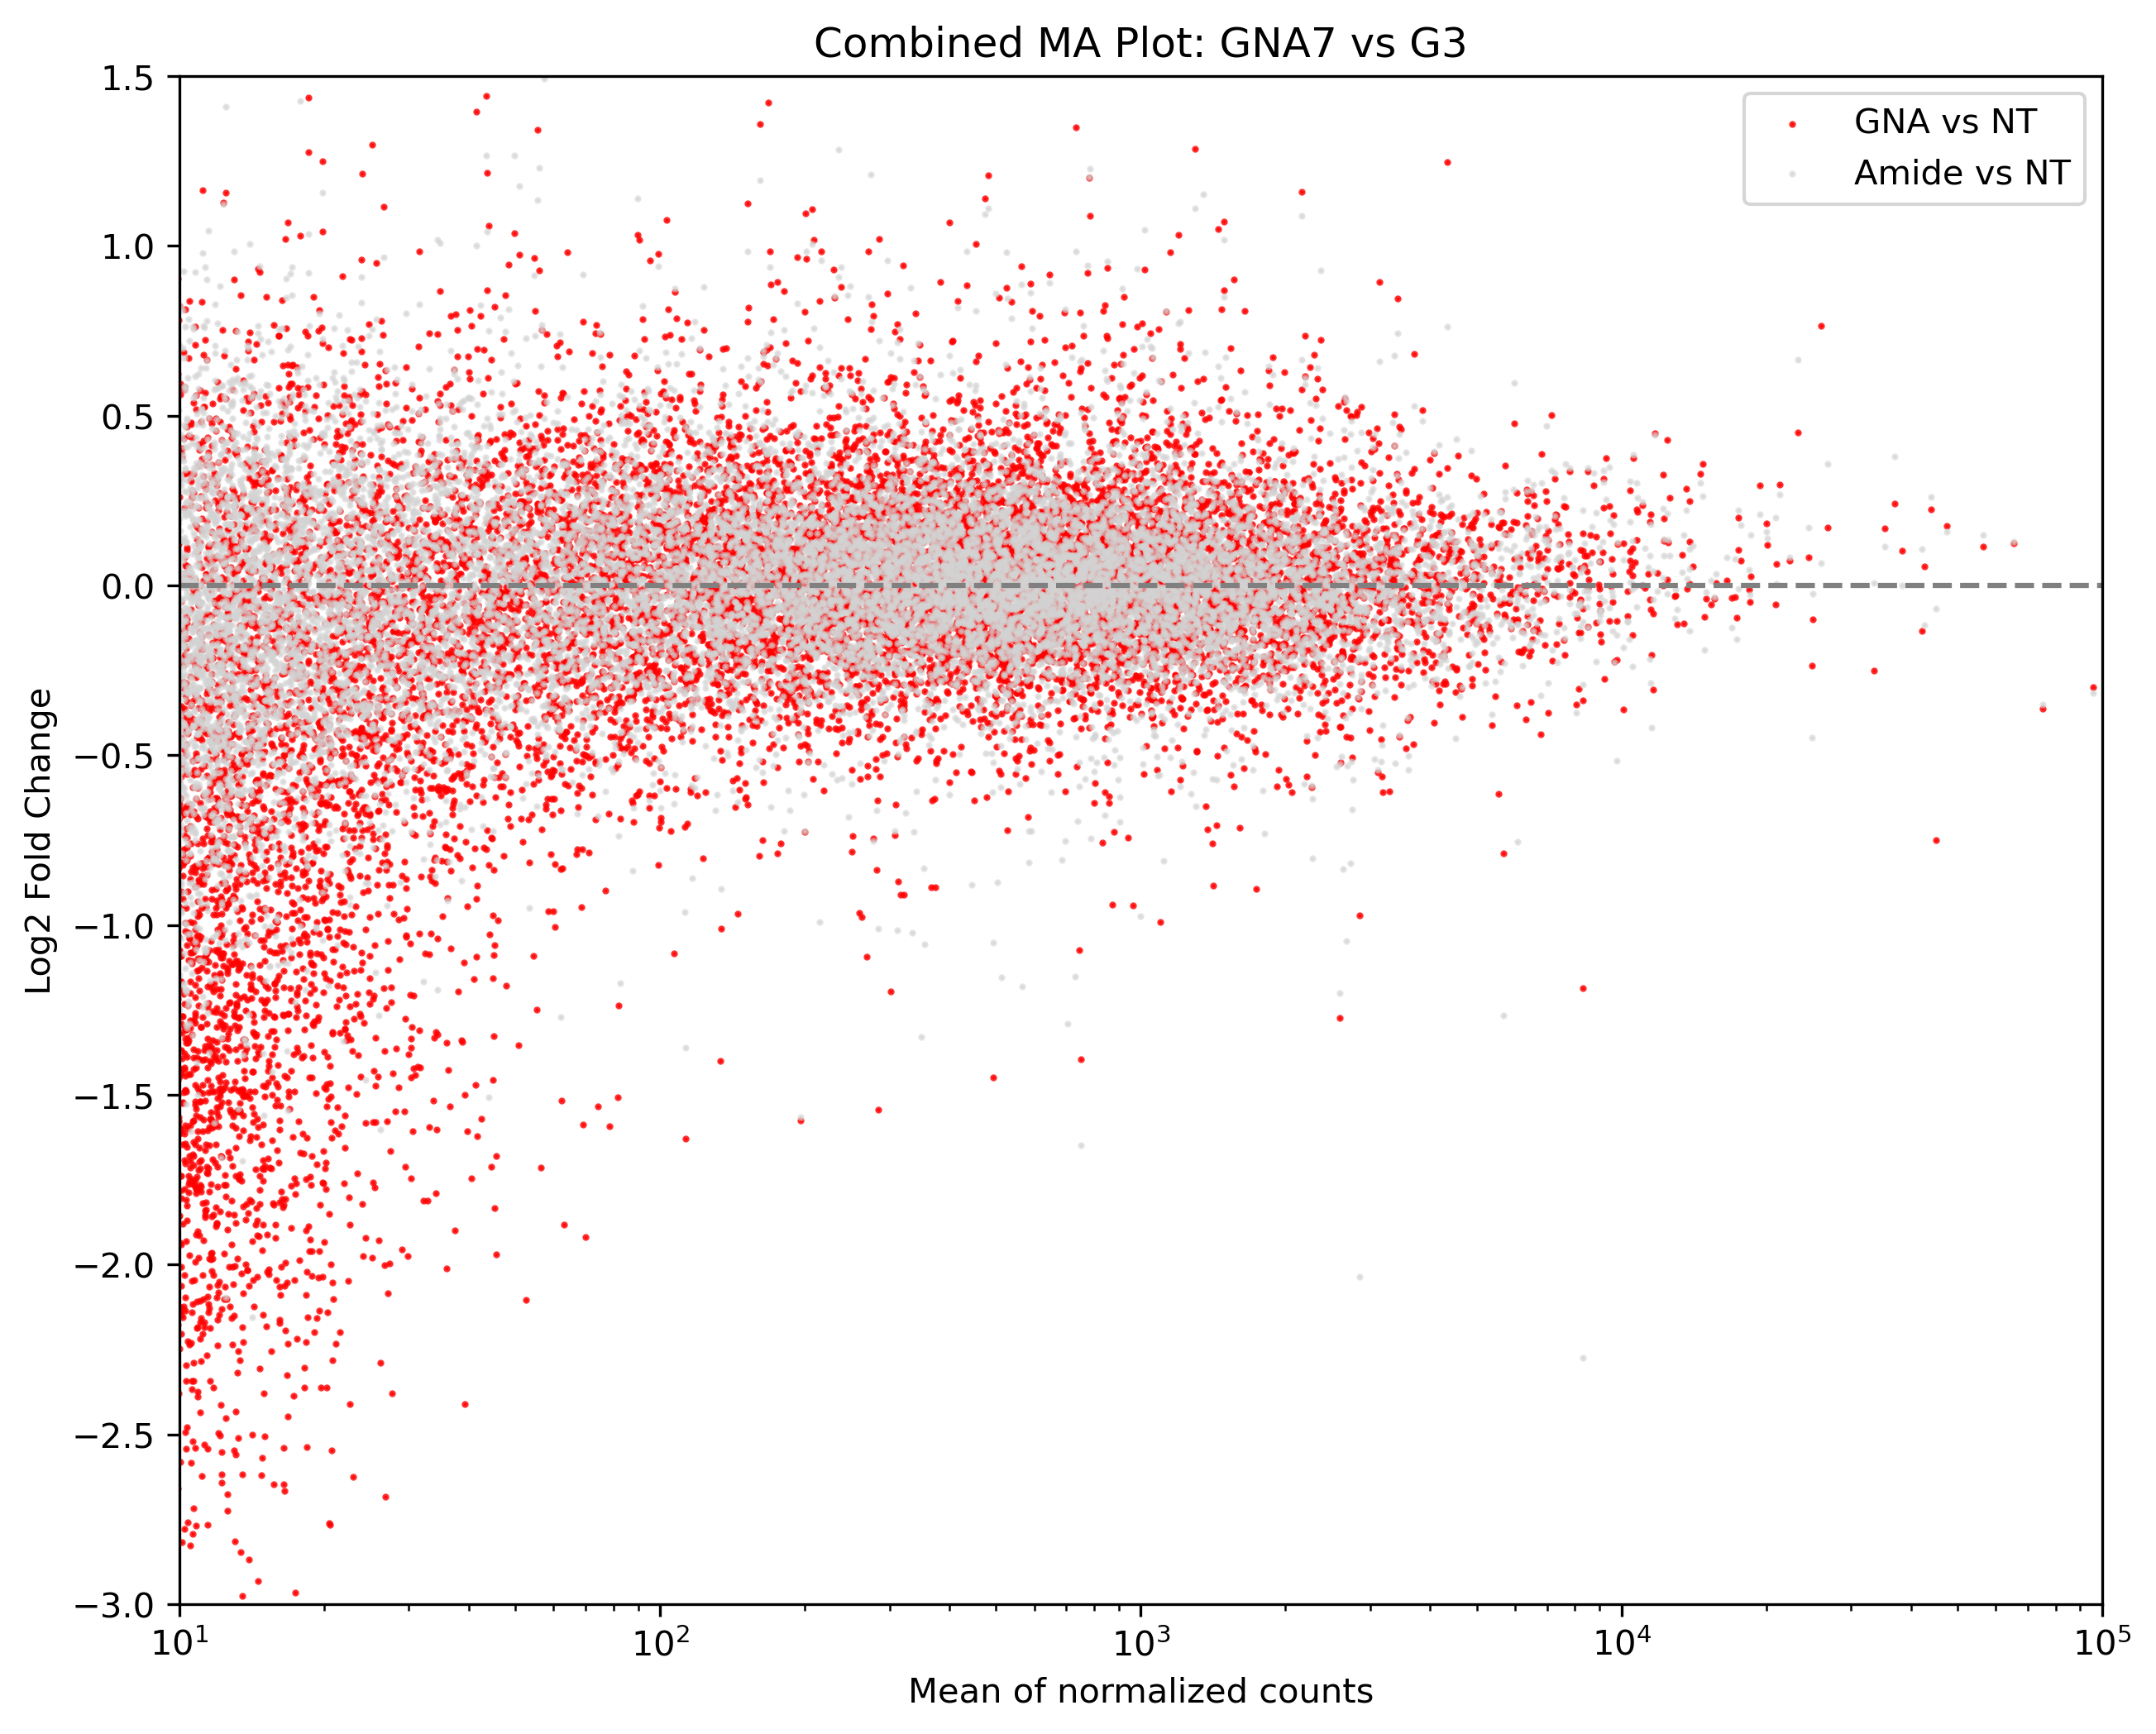

In [3]:
## MAPLOT  SEED MATCHED DATA, NORMALIZED, NO CUT OFF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("6048D_rawCounts.txt", sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    # mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    # plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
  plt.figure(figsize=(10, 8), dpi=300)

  plt.scatter(mean_counts, log_ratio1, color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
  plt.scatter(mean_counts, log_ratio2, color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2)

  plt.xscale('log')
  plt.ylim(-3, 1.5)
  plt.xlim(10**1, 10**5)
  plt.xlabel('Mean of normalized counts')
  plt.ylabel('Log2 Fold Change')
  plt.title(title)
  plt.axhline(0, color='gray', linestyle='--')
  plt.legend()

  if output_file:
    plt.savefig(output_file, bbox_inches='tight')

  plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: Unmod vs G3', 'combined_unmod_amide.png')
combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_unmod_amide.png')


/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/home/mrichte3/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


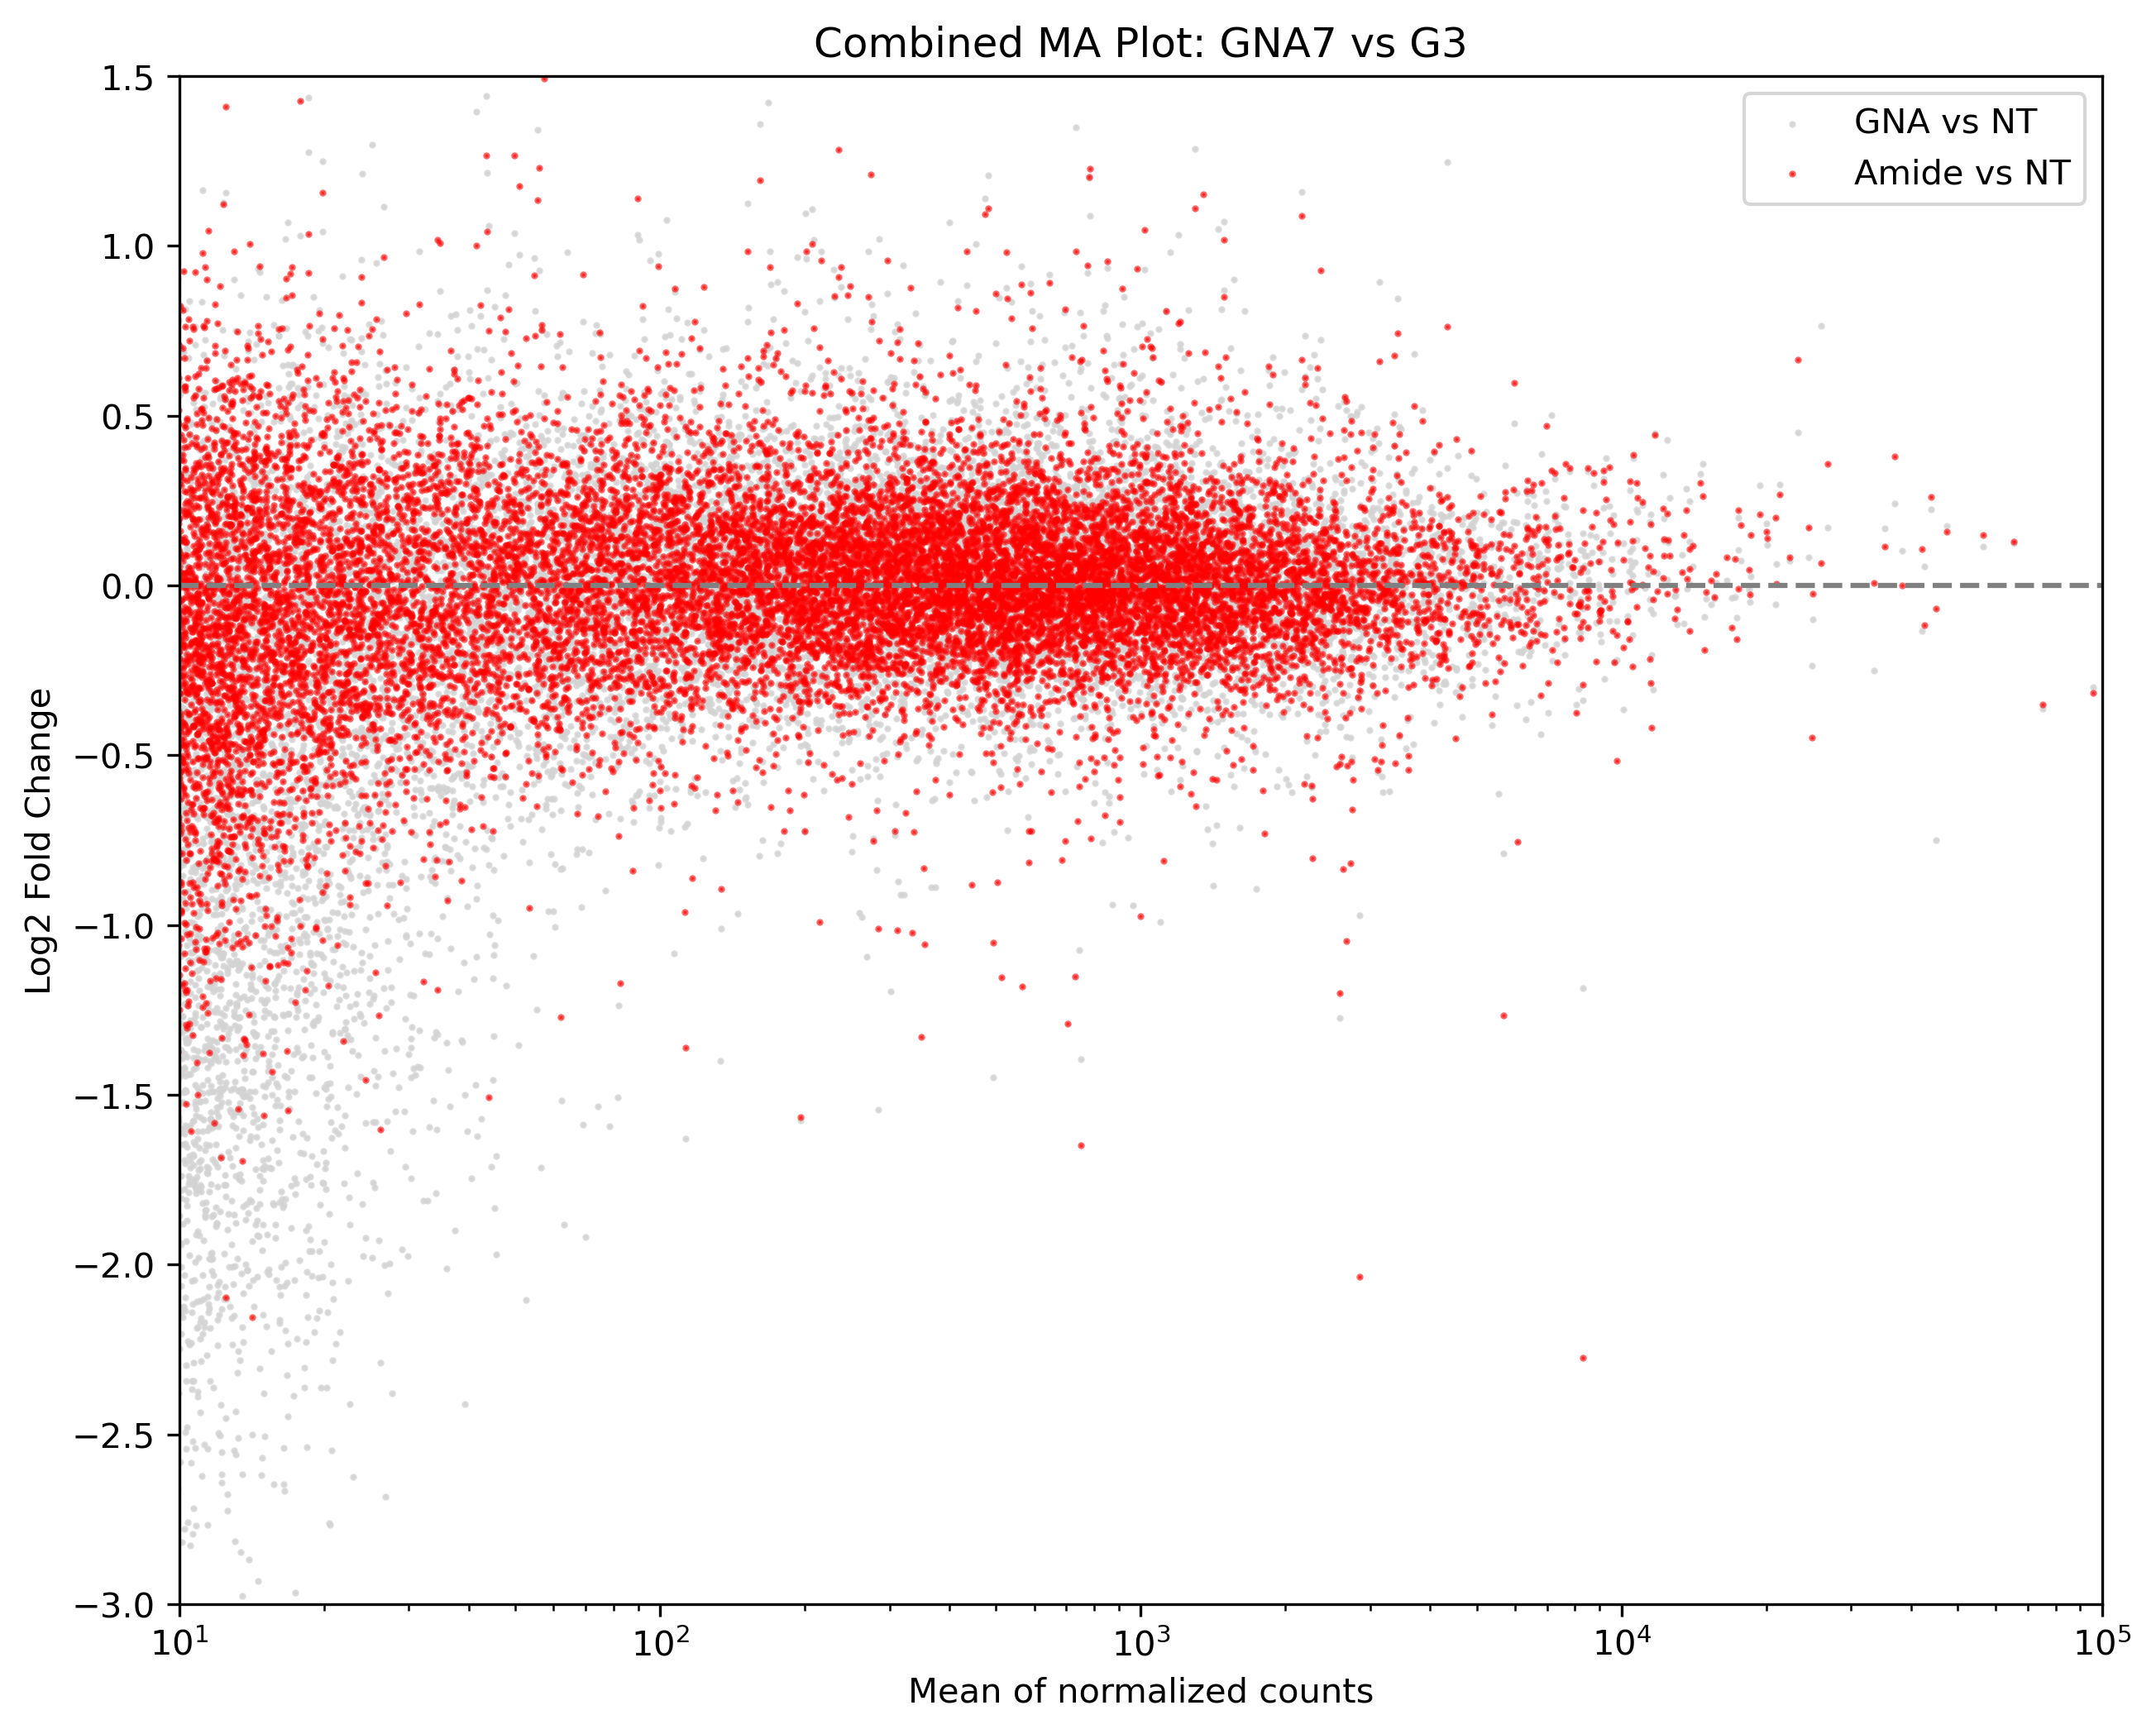

In [5]:
## MAPLOT SEED MATCHED DATA, NORMALIZED, NO CUT OFF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("6048D_rawCounts.txt", sep='\t', index_col=0)

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    # mask = mean_counts > 10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    # plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    plt.figure(figsize=(10, 8), dpi=300)

    plt.scatter(mean_counts, log_ratio1, color='lightgrey', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    plt.scatter(mean_counts, log_ratio2, color='red', alpha=0.6, s=1, label='Amide vs NT', zorder=2)

    plt.xscale('log')
    plt.ylim(-3, 1.5)
    plt.xlim(10**1, 10**5)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()

    if output_file:
        plt.savefig(output_file, bbox_inches='tight')

    plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: Unmod vs G3', 'combined_unmod_amide.png')
combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_unmod_amide.png')


In [14]:
print(df_normalized['mean_nt'].head())

ENSG00000000003    438.508363
ENSG00000000005      4.077700
ENSG00000000419    501.107720
ENSG00000000457    141.305651
ENSG00000000460    480.910586
Name: mean_nt, dtype: float64


In [ ]:
## matched_sequences2.csv SEED MATCHED DATA, NORMALIZED, NO CUT OFF
##################DO NOT CHANGE CODE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### MA PLOT OF THE SEED MATCHED DATA, NOT NORMALIZED, SHOWS DE IN RED
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('matched_sequences2.csv', index_col=0)
df = df.drop(columns=['region_around_match', 'sequence_length'])

columns_of_interest = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3', 'MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3',
                       'MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3', 'MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']
df_counts = df[columns_of_interest]

total_counts = df_counts.sum(axis=0)
scaling_factors = total_counts / total_counts.mean()
df_normalized = df_counts.div(scaling_factors, axis=1)

nt_cols = ['MR1_NT_1', 'MR2_NT_2', 'MR3_NT_3']
df_normalized['mean_nt'] = df_normalized[nt_cols].mean(axis=1)

unmod_cols = ['MR10_unmod_1', 'MR11_unmod_2', 'MR12_unmod_3']
amide_cols = ['MR4_Amide3_1', 'MR5_Amide3_2', 'MR6_Amide3_3']
gna_cols = ['MR7_GNA7_1', 'MR8_GNA7_2', 'MR9_GNA7_3']

df_normalized['mean_unmod'] = df_normalized[unmod_cols].mean(axis=1)
df_normalized['mean_amide'] = df_normalized[amide_cols].mean(axis=1)
df_normalized['mean_gna'] = df_normalized[gna_cols].mean(axis=1)

df_normalized['log2FC_unmod_vs_nt'] = np.log2(df_normalized['mean_unmod'] / df_normalized['mean_nt'])
df_normalized['log2FC_amide_vs_nt'] = np.log2(df_normalized['mean_amide'] / df_normalized['mean_nt'])
df_normalized['log2FC_gna_vs_nt'] = np.log2(df_normalized['mean_gna'] / df_normalized['mean_nt'])

def ma_plot_high_res(mean_counts, log_ratio, title, output_file=None):
    mask = mean_counts > 10 #10**0.5
    plt.figure(figsize=(10, 8), dpi=300)
    plt.scatter(mean_counts[mask], log_ratio[mask], alpha=0.3, s=1)
    # plt.scatter(mean_counts, log_ratio, alpha=0.3, s=1)
    plt.xscale('log')
    plt.ylim(-4, 4)
    plt.xlim(10**-1, 10**6)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    plt.show()

# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], 'Normalized Unmod vs NT', 'normalized_unmod_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_amide_vs_nt'], 'Normalized Amide vs NT', 'normalized_amide_vs_nt_high_res.png')
# ma_plot_high_res(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], 'Normalized GNA vs NT', 'normalized_gna_vs_nt_high_res.png')

def combined_ma_plot(mean_counts, log_ratio1, log_ratio2, title, output_file=None):
    mask = mean_counts > 10 #10**1  
    plt.figure(figsize=(10, 8), dpi=300)
    
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    # plt.scatter(mean_counts[mask], log_ratio1[mask], color='lightgrey', alpha=0.8, s=1, label='Unmod vs NT', zorder=1)
    # plt.scatter(mean_counts[mask], log_ratio2[mask], color='red', alpha=0.6, s=1, label='Amide vs NT', zorder=2) ## can reverse z order here
    plt.scatter(mean_counts[mask], log_ratio1[mask], color='red', alpha=0.8, s=1, label='GNA vs NT', zorder=1)
    plt.scatter(mean_counts[mask], log_ratio2[mask], color='lightgrey', alpha=0.6, s=1, label='Amide vs NT', zorder=2) 
    
    plt.xscale('log')
    plt.ylim(-2.5, 2.5)
    plt.xlim(10**1.5, 10**5)
    plt.xlabel('Mean of normalized counts')
    plt.ylabel('Log2 Fold Change')
    plt.title(title)
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    
    plt.show()

# combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_unmod_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: Unmod vs G3', 'combined_unmod_amide.png')
combined_ma_plot(df_normalized['mean_nt'], df_normalized['log2FC_gna_vs_nt'], df_normalized['log2FC_amide_vs_nt'], 'Combined MA Plot: GNA7 vs G3', 'combined_unmod_amide.png')
